In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/ITI_GP_Twenty Too"
! ls

Mounted at /content/drive
/content/drive/MyDrive/ITI_GP_Twenty Too


In [ ]:
! pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 2.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from tqdm import tqdm
import emoji
import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from xgboost import XGBClassifier
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 1000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Versions of libraries used :

In [ ]:
print("numpy version  : ",np.__version__)
print("pandas version  : ",pd.__version__)
print("re version  : ",re.__version__)
print("scikit-learn  : ",sklearn.__version__)
print("nltk version  : ",nltk.__version__)


numpy version  :  1.25.2
pandas version  :  2.0.3
re version  :  2.2.1
scikit-learn  :  1.2.2
nltk version  :  3.8.1


# Reading Data and pre-processing

In [ ]:
df = pd.read_csv('comment_vs_sentiment.csv', encoding='utf-8', engine='python')
df.dropna(inplace=True)

In [ ]:
df.head()

,comment,sentiment
0,When do you guys restock?,neutral
1,عالی😍🔥,positive
2,Dont buy in the app they are selling clothes without stock and after don’t return your money.,negative
3,👏👏🔥🔥,positive
4,❤️❤️❤️❤️,positive


In [ ]:
df["sentiment"].value_counts()

sentiment
positive    14873
neutral      9544
negative     4544
unknown         1
Name: count, dtype: int64

In [ ]:
df = df[df['sentiment'] != 'unknown']

In [ ]:
X_train, X_other, y_train, y_other = train_test_split(df['comment'], df['sentiment'], test_size=0.2, shuffle=True, stratify=df['sentiment'], random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, shuffle=True, stratify=y_other, random_state=123)
train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## 1- Multinominal Naive-Bayes :

In [ ]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight = {i: weight for i, weight in enumerate(class_weights)}
class_weight

{0: 2.124530032095369, 1: 1.0114822091246454, 2: 0.6490726732784221}

In [ ]:
class_weight_lr = {'negative': 2.124530032095369, 'neutral': 1.0114822091246454, 'positive': 0.6490726732784221}

In [ ]:
total_weight = sum(class_weight.values())
class_prior = [class_weight[i] / total_weight for i in range(len(class_weight))]
print(class_prior)

[0.5612899261407697, 0.267228406224191, 0.1714816676350393]


In [ ]:
mnb = MultinomialNB(class_prior=class_prior)
tfidf_vectorizer = TfidfVectorizer(max_features=250000)
count_vectorizer = CountVectorizer(max_features=250000)
target_labels = ['+ve', '0neu', '-ve']


In [ ]:
class Demojizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [emoji.demojize(text) for text in X]

## 2- Logistic Regression :

In [ ]:
class_weights

array([2.12453003, 1.01148221, 0.64907267])

# Approximately Logistic-Regression is slightly better than Multi-nominal Naive Bayes

# `Create Voter Classifier : `

              precision    recall  f1-score   support

    negative       0.66      0.85      0.74       455
     neutral       0.82      0.77      0.79       954
    positive       0.95      0.91      0.93      1487

    accuracy                           0.85      2896
   macro avg       0.81      0.84      0.82      2896
weighted avg       0.86      0.85      0.85      2896



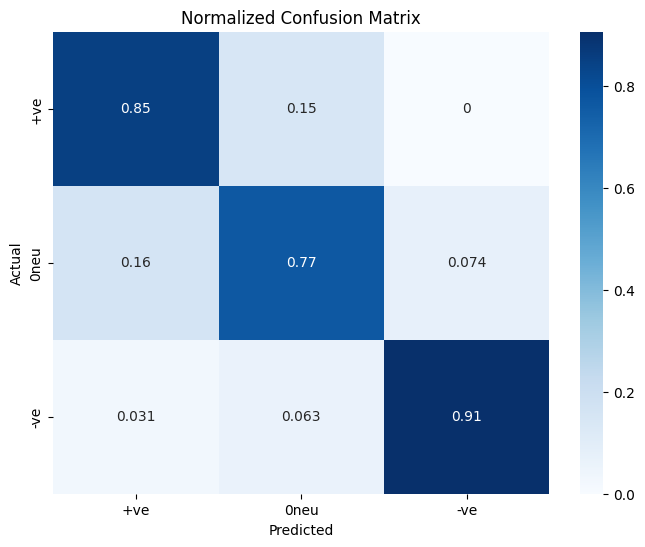

In [ ]:
count_vectorizer = CountVectorizer(max_features=1000000)
tfidf_vectorizer = TfidfVectorizer(max_features=1000000)

lr1 = LogisticRegression(class_weight=class_weight, max_iter=50000, C=1)
mnb1 = MultinomialNB(class_prior=class_prior)
voting_clf = VotingClassifier(estimators=[('mnb1', mnb1),('lr1', lr1)], voting='soft')

pipeline = Pipeline(steps=[
    ('demojizer', Demojizer()),
    ('Vectorizing', count_vectorizer),
    ('voter', voting_clf),
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
report = classification_report(y_val, y_pred)
print(report)

normalized_cm = confusion_matrix(y_val, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

# Train to Whole Dataset and, Finaaaaaaallllyyyy save ⚡

              precision    recall  f1-score   support

    negative       0.81      0.95      0.87       455
     neutral       0.91      0.88      0.89       954
    positive       0.97      0.94      0.95      1487

    accuracy                           0.92      2896
   macro avg       0.89      0.92      0.91      2896
weighted avg       0.92      0.92      0.92      2896



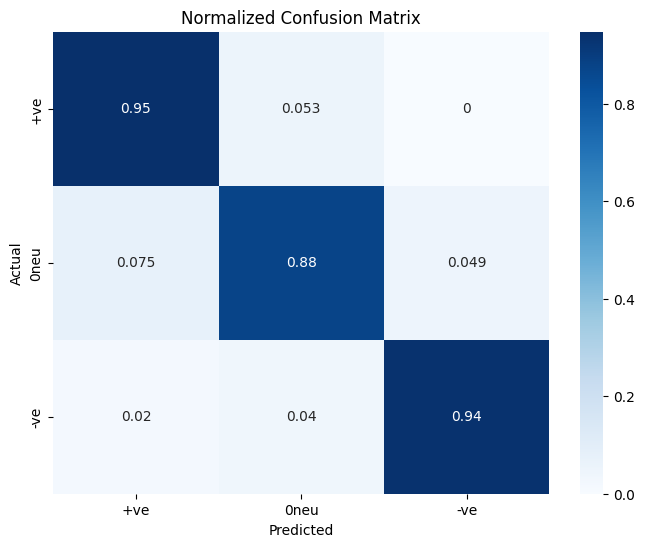

In [ ]:
count_vectorizer = CountVectorizer(max_features=1000000)
tfidf_vectorizer = TfidfVectorizer(max_features=1000000)

lr1 = LogisticRegression(class_weight=class_weight, max_iter=50000, C=1)
mnb1 = MultinomialNB(class_prior=class_prior)
voting_clf = VotingClassifier(estimators=[('mnb1', mnb1),('lr1', lr1)], voting='soft')

pipeline = Pipeline(steps=[
    ('demojizer', Demojizer()),
    ('Vectorizing', count_vectorizer),
    ('voter', voting_clf),
])

pipeline.fit(df["comment"], df["sentiment"])
y_pred = pipeline.predict(X_val)
report = classification_report(y_val, y_pred)
print(report)

normalized_cm = confusion_matrix(y_val, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()


In [ ]:
import joblib
joblib.dump(pipeline, 'SA.pkl')

# Load it to check it is properly saved ✅
loaded_pipeline = joblib.load('SA.pkl')



## Final Testing :

In [ ]:
y_pred_final = loaded_pipeline.predict(X_test)
report = classification_report(y_test, y_pred_final)
print(report)

              precision    recall  f1-score   support

    negative       0.81      0.94      0.87       454
     neutral       0.90      0.89      0.89       955
    positive       0.97      0.92      0.94      1488

    accuracy                           0.92      2897
   macro avg       0.89      0.92      0.90      2897
weighted avg       0.92      0.92      0.92      2897



## ============================ The End ===============================